In [15]:
%reset -f

# Code optimization and good practices: make the best of Python

*Python bootcamp@SAp*, Marc Joos (LMPA) 

This Notebook is under a [**CreativeCommons BY-NC-SA v.4.0**](https://creativecommons.org/licenses/by-nc-sa/4.0/) license.

## Preamble: optimize what needs to be optimized

> *Premature optimization is the root of all evil.*
>
>                            — Donald Knuth

A good developement pattern is something like:
 1. get your program right
 2. test it right
 3. profile it if you're not satisfy with the performance
 4. optimize
 5. repeat from 2.

## Profiling

### 1. The IPython `%timeit` magic function

`%timeit` is very convenient to profile pieces of code in the interactive IPython shell.

In [1]:
def loop(nx=100, ny=100):
    for i in range(nx):
        for j in range(ny):
            res = i**2 + i*j
    return res

%timeit loop()

100 loops, best of 3: 14.5 ms per loop


### 2. cProfile

**cProfile** is the Python profiling interface. It can be use to profile a whole code, and can be called just through your shell command line.

In [3]:
import cProfile
cProfile.run('loop()')

         4 function calls in 0.007 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.007    0.007    0.007    0.007 <ipython-input-2-0922eee08823>:1(loop)
        1    0.000    0.000    0.007    0.007 <string>:1(<module>)
        1    0.000    0.000    0.007    0.007 {built-in method exec}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




Or, in your favorite shell:

`~$ python -m cProfile myscript.py`

You should be careful though, **cProfile** is designed to give the profile of a given program, but shouldn't be used for benchmarking purpose. The profiler introduces overhead in the Python code that are not in your C/Fortran/whitespace functions; they will inevitably look faster!

## Speed up your code I: Cython

Python is slow because it is an interpreted language; everything as to be evaluated on the fly, with little or no possibility of optimization by the interpreter. C, Fortran and other compiled languages are more efficient because the processor can optimize lots of things at compile time. But most of the time, if you use Python you probably don't want to swith to a compiled language, with a steeper learning curve, little or no plotting possibilities, and a longer development cycle.

**Cython** is a good starting point to optimize your code, without modifying it too much or relying too strongly on bits of code written in another language. The idea is very simple: take you Python code, define some variables in a C-like way, and compile it as a C module.

### First steps

Let's try with a simple function to compute $\pi$, by integrating $f(x) = \frac{4}{1 + x^2}$:

In [16]:
import numpy as np

f = lambda x: 4./(1. + x*x)

def compPi(niter=1000):
    h  = 1./niter
    pi = 0.
    for i in range(niter):
        x   = h*(i - 0.5)
        pi += f(x)
    error = abs(np.arccos(-1.) - pi*h)/np.arccos(-1.)
    return pi*h, error

If we time it, we get:

In [17]:
pipyversion = %timeit -o compPi()
times = []; labels = []
times.append(pipyversion.best)
labels.append('Python')

1000 loops, best of 3: 1.07 ms per loop


The first step is to copy/paste your code in a `.pyx` file, that you will then compile.

(For the sake of simplicity for the workshop, I'll use the magic `cython` function.)

In [18]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [19]:
%%cython
import numpy as np

f = lambda x: 4./(1. + x*x)

def compPi_cython(niter=1000):
    h  = 1./niter
    pi = 0.
    for i in xrange(niter):
        x   = h*(i - 0.5)
        pi += f(x)
    error = abs(np.arccos(-1.) - pi*h)/np.arccos(-1.)
    return pi*h, error

Let's time it:

In [20]:
picy1version = %timeit -o compPi_cython()
times.append(picy1version.best)
labels.append('Cython\n(copy-paste)')

1000 loops, best of 3: 574 µs per loop


Which is pretty cool: doing nothing but a copypasta, we already improved the performance! But we can do better; first, by declaring some variables, second, by redefining our `f` function in a C way (using `cdef` instead of `def`):

In [21]:
%%cython
import numpy as np

cdef double f(double x):
    return 4./(1. + x*x)

def compPi_cython(int niter=1000):
    cdef:
        int i
        double error
        double h  = 1./niter
        double pi = 0.
    for i in range(niter):
        x   = h*(i - 0.5)
        pi += f(x)
    error = abs(np.arccos(-1.) - pi*h)/np.arccos(-1.)
    return pi*h, error

In [22]:
picy2version = %timeit -o compPi_cython()
times.append(picy2version.best)
labels.append('Cython\n(with cdef)')

10000 loops, best of 3: 28.4 µs per loop


**Note:** Since `f` was defined using `cdef`, it can be called only in the Cython module. The advantage is that it is closer to a "real" C function, and it removes some overheads of the Python functions. If you need the function to be called both from Cython and Python, you can use `cpdef`; it will then produce (at compile time) two versions of the function: one for Cython, and one for Python.

Cython comes with directives (that you can use as decorator) to further optimize your code. In particular, there is (find all the directives on the [Cython compilation page](http://docs.cython.org/src/reference/compilation.html)):
- `boundcheck`: if `False`, Cython presumes the indices existence (default: `True`);
- `wraparound`: if `False`, Cython does not check if the index is negative (default: `True`);
- `cdivision`: if `True`, Cython uses C division (default: `False`).

Let's try:

In [23]:
%%cython
import cython
import numpy as np

@cython.cdivision(True)
cdef double f(double x):
    return 4./(1. + x*x)

def compPi_cython(int niter=1000):
    cdef:
        int i
        double error
        double h  = 1./niter
        double pi = 0.
    for i in range(niter):
        x   = h*(i - 0.5)
        pi += f(x)
    error = abs(np.arccos(-1.) - pi*h)/np.arccos(-1.)
    return pi*h, error

In [24]:
picy3version = %timeit -o compPi_cython()
times.append(picy3version.best)
labels.append('Cython\n(with decorators)')

100000 loops, best of 3: 19.5 µs per loop


Let's plot these results to summarize what we have achieve so far:

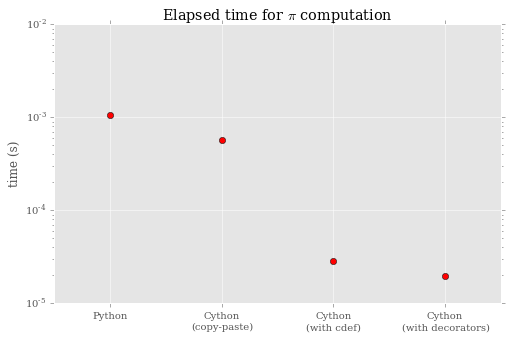

In [25]:
%matplotlib inline
import pylab as pl
pl.style.use("ggplot")

def plotElpTime(times, labels, *args, **kwargs):
    fig = pl.figure(figsize=(len(times)*2,5))
    pl.title(r'Elapsed time for $\pi$ computation')
    pl.ylabel('time (s)')
    pl.xticks(range(len(times)), labels)
    pl.xlim(-0.5, len(times)-0.5)
    pl.semilogy(times, 'ro')
    return fig
 
fig = plotElpTime(times, labels)

### Calling other Cython modules in Cython

A Cython script can be split in two parts, one with the declarations (a `.pxd` file) and one with the rest of the code (a `.pyx` file). Then, if you need something declared in another Cython module's definition file, you can `import` (for Python-like functions) or `cimport` (for C like functions) the module in your code:

``` python
# First Cython module (mod1.pyx)

cdef myFunc(type arg):
    doSomething
    return things

def myPyFunc(type arg):
    doSomething
    return things
```

``` python
# Definition file (mod1.pxd)

cdef myFunc(type arg)
def myPyFunc(type arg)
```

``` python
# Second Cython module (another pyx file)
cimport mod1 as cmod1
import mod1 as pmod1

cdef anotherFunc(type arg):
    something = pmod1.myPyFunc(arg)
    somethingElse = cmod1.myFunc(arg)
    return otherThings
```

In particular, NumPy can be interfaced with Cython using this:

In [26]:
# Python version:
import numpy as np

def dummyLoop(nx=100, ny=100):
    arr = np.zeros((nx,ny))
    for i in range(nx):
        for j in range(ny):
            arr[i,j] = i*i + i*j
    return arr

In [27]:
%timeit dummyLoop()

100 loops, best of 3: 9.31 ms per loop


In [28]:
%%cython
# Cython version:
import numpy as np
cimport numpy as cnp

def dummyLoop_cython(int nx=100, int ny=100):
    cdef cnp.ndarray[cnp.float64_t, ndim=2] arr = np.zeros((nx,ny))
    for i in range(nx):
        for j in range(ny):
            arr[i,j] = i*i + i*j
    return arr

In [29]:
%timeit dummyLoop_cython()

100 loops, best of 3: 2.74 ms per loop


### Wrapping C/C++ functions with Cython

Cython allows you also to wrap C/C++ functions, with the same mechanism:

In [30]:
# Header file

cdef extern from "math.h":
    double sin(double angle)
    double cos(double angle)

SyntaxError: invalid syntax (<ipython-input-30-54f35ed10609>, line 3)

### Compiling

In real life, you'll need to compile your Cython scripts. To do so, you have to put your Cython program in a `.pyx` file, and then you just have to create a Makefile that looks like this:

    FCC = gcc
    PYINC = $CONDAPATH/include/python2.7 # with $CONDAPATH the path of your current Anaconda installation

    all:
        cython cutils.pyx
        $(FCC) -fPIC -shared -O3 -Wall -fno-strict-aliasing -I$(PYINC) -o cutils.so cutils.c

Then, all you have to do is to compile the script with `make`, and call it in your Python scripts with

    import cutils

## Speed up your code II: `ctypes`

Another alternative to directly wrap your C code in Python is **`ctypes`**. `ctypes` is from the standard library, and actually allows you to call any C compiled library into Python. It is slightly less user-friendly than Cython, and it is very architecture-specific: the library extensions are not the same on different plateforms (Windows `dll` vs. \*NIX `so`), and you can have 32/64bit problems.

That being said, you can proceed first by creating your C source:

In [31]:
%%file mylib.c
#include <math.h>

double f(double x) {
        return 4./(1. + x*x); 
}

double compPi_ctypes(double pi, int niter) {
    double h = 1./niter;
    double x = 0.;
    for (int i=0; i<niter; ++i){
        x = h*(i - 0.5);
        pi += f(x);
    }
    pi *= h;
    return pi;
}

Overwriting mylib.c


In [32]:
%%bash
gcc -std=c99 -c -fPIC mylib.c
gcc -shared -o mylib.so mylib.o

In [33]:
import ctypes

# import the C library
mylib = ctypes.CDLL('mylib.so')
# declare result type: default is int
mylib.compPi_ctypes.restype = ctypes.c_double
# declare arguments type
pi = ctypes.c_double(0.); niter = ctypes.c_int(1000)

pictversion = %timeit -o mylib.compPi_ctypes(pi, niter)
times.append(pictversion.best)
labels.append('C')

The slowest run took 5.04 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 20.6 µs per loop


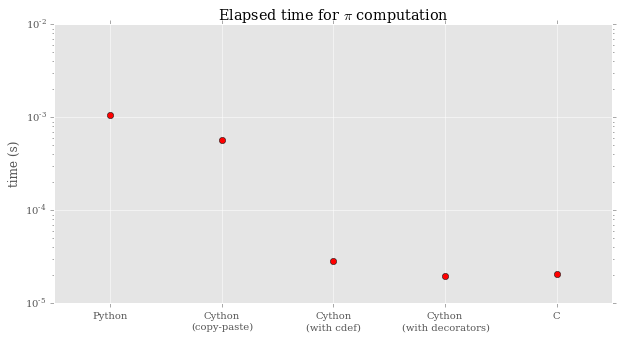

In [34]:
fig = plotElpTime(times, labels)

## Speed up your code III: f2py

`f2py` is to Fortran what `ctypes` is to C: you can wrap directly your fortran routines in a Python module. it comes from NumPy, and you'll obviously need a Fortran compiler on your machine to use it.

In [35]:
%%file futils.f90
module futils
contains
    function f(x) result(res)
        implicit none
        real(8), intent(in) :: x
        real(8) :: res
                
        res = 4.d0/(1.d0 + x*x)
    end function f
    

    subroutine compPi_fortran(pi, error, niter)
        implicit none
        
        integer, intent(in) :: niter
        real(8), intent(out) :: pi, error
        real(8) :: h, x
        integer :: i        

        h = 1.d0/niter
        pi = 0.d0
        error = 0.d0
        
        do i = 1, niter
            x = h*(i - 0.5d0)
            pi = pi + f(x)
        enddo
        pi = pi*h
        
        error = abs(acos(-1.d0) - pi)/acos(-1.d0)
    end subroutine compPi_fortran

end module futils

Writing futils.f90


Then compile it with `f2py`; the `-m futils` option sets the name of the Python module it will produce:

In [36]:
!f2py -c -m futils futils.f90 

/bin/sh: f2py: command not found


And this can be simply called from Python, as any Python module:

In [ ]:
from futils import futils

pifpyversion = %timeit -o futils.comppi_fortran(1000)
times.append(pifpyversion.best)
labels.append('F2Py')

In [ ]:
fig = plotElpTime(times, labels)

You can also pass NumPy arrays transparently between Python and your Fortran module:

In [37]:
%%file futils_arr.f90
module futils_arr
contains
    subroutine loop_fortran(arr, nx, ny)
        implicit none
        integer, intent(in) :: nx, ny
        integer, dimension(nx,ny), intent(inout) :: arr
        integer :: i, j
                
        do j = 1, ny
            do i = 1, nx
                arr(i,j) = i*i + i*j
            enddo
        enddo
        
    end subroutine loop_fortran
end module futils_arr

Writing futils_arr.f90


In [ ]:
!f2py -c -m futils futils.f90

In [ ]:
import numpy as np
from futils_arr import futils_arr

nx = 100; ny = 100
arr = np.zeros((nx,ny), dtype='i4', order='F')
%timeit futils_arr.loop_fortran(arr)

Note that I had to define the order of the numpy array; by default, arrays are C-ordered (meaning in row-major order), whereas Fortran arrays are column-major ordered. The order of a NumPy array can be set with the `order` option, with `C` for C-order and `F` for Fortran-order.

If you want to pass an existing array to Fortran, you can copy it and just change its order:

In [ ]:
import sys

# Check array order
def arrayOrder(arr):
    try:
        assert(type(arr) == np.ndarray)
    except AssertionError:
        'This is not an array'
        sys.exit(0)
    orderF = arr.flags.f_contiguous
    orderC = arr.flags.c_contiguous
    if orderF and orderC:
        return 'array is in C and Fortran order'
    elif orderF:
        return 'array is in Fortran order'
    else:
        return 'array is in C order'

arr = np.zeros((nx,ny))
print ('arr: ' + arrayOrder(arr))
arrF = arr.copy(order='F')
print ('arrF: ' + arrayOrder(arrF))

### f2py with interface

You probably noticed that we had to define the array returned by `f2py` before calling the function, which seems a bit awkward. In this particular case, would seem more logical to pass the dimensions of the desired array, and to get as a result an array.

It can actually be done using an *interface file*, that is kind of a header file for `f2py`, with a `pyf` extension. This file can be automatically generated by `f2py`:

In [ ]:
!f2py --overwrite-signature futils.f90 -m futils -h futils.pyf

In [ ]:
!more futils.pyf

We can therefore simply rewrite this file, redefining the array as an `intent(out)` variable, with a dependency on the array dimensions. The dimensions just need to be `intent(in)` variables, with no dependency:

In [ ]:
%%file futils.pyf
!    -*- f90 -*-
! Note: the context of this file is case sensitive.

python module futils ! in 
    interface  ! in :futils
        module futils ! in :futils:futils.f90
            subroutine loop_fortran(arr,nx,ny) ! in :futils:futils.f90:futils
                integer, dimension(nx,ny), intent(out), depend(nx,ny) :: arr
                integer, intent(in) :: nx
                integer, intent(in) :: ny
            end subroutine loop_fortran
        end module futils
    end interface 
end python module futils

! This file was auto-generated with f2py (version:2).
! See http://cens.ioc.ee/projects/f2py2e/

Let's recompile and call it from Python:

In [ ]:
!f2py -c -m futils futils.pyf futils.f90

In [ ]:
from futils import futils
%timeit futils.loop_fortran(100, 100)

## Speed up your code IV: Numba

One advantage of using Python is to avoid all the compilation steps and all the associated inconveniences. Clearly, with all the previous examples, the compilation step seems once again unavoidable if you want to keep up with good performances.

However, with tools as **Numba**, this can be avoided. Numba is a *Just-In-Time compiler* relying on LLVM; it means that machine code can be generated dynamically, on the fly, during the execution.

**Numba** can be use simply with the `autojit` decorator:

In [40]:
from numba import autojit

# The Python functions to compute pi:
f = lambda x: 4./(1. + x*x)

def compPi(niter=1000):
    h  = 1./niter
    pi = 0.
    for i in range(niter):
        x   = h*(i - 0.5)
        pi += f_numba(x)
    error = abs(np.arccos(-1.) - pi*h)/np.arccos(-1.)
    return pi*h, error

# The Just-In-Time-compiled version:
@autojit
def f_numba(x):
    return 4./(1. + x*x)

@autojit
def compPi_numba(niter=1000):
    h  = 1./niter
    pi = 0.
    for i in range(niter):
        x   = h*(i - 0.5)
        pi += f_numba(x)
    error = abs(np.arccos(-1.) - pi*h)/np.arccos(-1.)
    return pi*h, error

In [41]:
%timeit compPi(1000)
pinumbaversion = %timeit -o compPi_numba(1000)
times.append(pinumbaversion.best)
labels.append('Numba')

The slowest run took 167.34 times longer than the fastest. This could mean that an intermediate result is being cached 
1000 loops, best of 3: 430 µs per loop
The slowest run took 16973.11 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 4.8 µs per loop


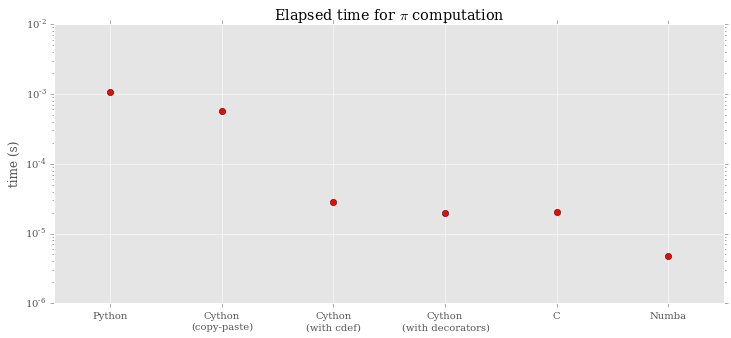

In [42]:
fig = plotElpTime(times, labels)

And therefore, with almost no effort or modifications of the code, we get a results only a few percents slower than the best we had with compiled code.

Bad news is Numba is still young and still struggle to take the best of Python, in particular with complex code -- it can be slower than pure Python+NumPy. It does not support (yet?) list comprehension either. But it is always worth trying, to see what you can achieve with this simple approach.

## Speed up your code V: other alternatives

There are other existing alternatives to Cython, ctypes, f2py or numba I presented here. In particular, there is:
- [Python C API](http://docs.python.org/2/c-api/): Python is implemented in C, and you can actually write C code which will compile to a Python module! This is extremely low-level, and I would only recommend it if you enjoy pain (see Dan Foreman-Mackie's [blog post](http://dan.iel.fm/posts/python-c-extensions/) for a concise-as-possible introduction);
- [SWIG](http://www.swig.org/): the Simplified Wrapper Interface Generator, can generate wrappers from a variety of low-level languages to a variety of high-level languages.  It's used heavily by LSST and other projects;
- [Weave](http://docs.scipy.org/doc/scipy/reference/tutorial/weave.html): included in SciPy, weave is a method of putting C snippets within a Python program.  It's largely been superseded by Cython in practice;
- [PyPy](http://pypy.org/): a JIT compiler for Python written in Python.  PyPy doesn't support the C backend which most scientific tools rely on, so it's not extremely useful for scientific computing. Typically, forget it if you use NumPy (and I guess I just lost everybody in the room).

## Speed up your code VI: Concurrent and parallel computing with Python

### 1. Multiprocessing

Python allows, to a certain point, to use **parallel** or **concurrent** computing, using multiple threads or processes.The simplest, to use concurrency, is to use the `multiprocessing` package. `multiprocessing` is using processes and not threads because of the Python interpreter that is not thread-safe: some internal data structures are accessible by one thread and one thread only at a time, and everything is under control by the GIL (Global Interpreter Lock). To circumvent this problem, multprocessing is using different processes on which the critical data structures are independently copied.

In the first example, we create a process for every call (here of a function, that will perform a given task) we want to do.

In [ ]:
import os
import multiprocessing as mp

def doSomething(wdir='./'):
    print('working on process: %d' %os.getpid())
    print(os.listdir(wdir))
    
def launchSimple(listdir=('./', '../',)):
    for wdir in listdir:
        # Create processes
        p = mp.Process(target=doSomething, args=(wdir,))
        # Launch processes
        p.start()
        # Wait until processes terminate
        p.join()
        
launchSimple()

We see the limitation of this first example: we can execute in parallel independent tasks, but we cannot get back the results. The simplest is to use a queue, in which we will put the results of every process:

In [ ]:
def doItInQueue(q, wdir='./'):
    print('working on process: %d' %os.getpid())
    q.put(os.listdir(wdir))
    
def launchQueue(listdir=('./', '../',)):
    # Create queue
    q = mp.Queue()
    result = []
    for wdir in listdir:
        # Create processes
        p = mp.Process(target=doItInQueue, args=(q, wdir))
        # Launch processes
        p.start()
        # Wait until processes terminate
        p.join()
        # Get results
        result.append(q.get())
    return result

launchQueue()

Then, reading the multiprocessing documentation, you realize that you could it in an even simpler way, using pools of processes with `Pool()`. Pools come with a map method, that works as the classical map function in Python (you can map a function on a list of arguments):

In [ ]:
def doItInPool(wdir='./'):
    print('working on process: %d' %os.getpid())
    return os.listdir(wdir)

def launchPool(listdir=['./', '../']):
    # Get number of CPU available and define the number of processes
    nproc  = mp.cpu_count()*2
    # Create pool
    pool   = mp.Pool(processes=nproc)
    # Distribute the work among processes
    result = pool.map(doItInPool, listdir)
    return result

launchPool()

Lastly, for a more advance use, you can create queues to manage both the tasks to execute and the results to get back, with workers:

In [ ]:
def doItWithWorker(tasks, results):
    for i, task in iter(tasks.get, 'STOP'):
        results.put((i, os.getpid(), os.listdir(task)))
    
def launchWorker(listdir=['./', '../']):
    # Get number of CPU available and define the number of processes
    nproc   = mp.cpu_count()*2
    # Create queues
    tasks   = mp.Queue()
    results = mp.Queue()

    # Create list of tasks
    for i, out in enumerate(listdir):
        tasks.put((i, out))

    # Distribute the work among processes
    for i in xrange(nproc-1):
        p = mp.Process(target=doItWithWorker, args=(tasks, results))
        p.start()

    # Tell processes to stop when they are done
    for i in xrange(nproc-1):
        tasks.put('STOP')
    
    # Gather results
    result = []
    for i in xrange(len(listdir)):
        j, pid, res = results.get()
        print('Task #%02d was done on process #%d' %(j,pid))
        result.append(res)

    return result

launchWorker()

### 2. mpi4py

A very last alternative is to use `mpi4py`. For one used to parallel programming, it is utterly simple to use: you just have to create a global communicator, and then to do your domain decomposition. In the end, you could retrieve the data through a communication (typically a `comm.Gather()` call in this example).

In [ ]:
%%file parallel.py
#!/usr/bin/env python
import os
import argparse
from mpi4py import MPI

def launchMPI(listdir=['./', '../']):
    # Initialize MPI creating COMM_WORLD communicator
    comm = MPI.COMM_WORLD
    # Get size of the MPI domain and rank of the process
    size = comm.Get_size()
    rank = comm.Get_rank()
    
    # Distribute work among MPI processes
    nfp = len(listdir)/size
    for i in xrange(nfp+1):
        idx = i*size + rank
        print('working on process: %d with PID: %d' %(rank,os.getpid()))
        if idx < len(listdir):
            print(os.listdir(listdir[idx]))
        else:
            print('Nothing to be done.')

def main():
    parser = argparse.ArgumentParser(description='')
    parser.add_argument('--with-mpi', '-m', dest='mpi', action='store_true' \
                            , help='to launch MPI test')
    args = parser.parse_args()

    mpi = args.mpi
    if mpi: launchMPI()

if __name__ == '__main__':
    main()

In [ ]:
%%bash
chmod +x parallel.py
mpirun -np 4 ./parallel.py -m

## Useful tips and tricks

### 1. `range` vs. `xrange` -- always prefer iterators!

 - `range(n)` generates a list of `n` elements, that is stored in memory
 - `xrange(n)` generates an iterator; integers are generated when requested

In [ ]:
import sys

print sys.getsizeof(range(1000))
print sys.getsizeof(xrange(1000))

And there are lots of already-made iterators waiting for you out there. Typically, dictonaries also come with iterators:

In [ ]:
dict_ = {'rho': 1.e3, 'P': 1.e2, 'v': 42.}
# Works also with 'values' and 'items'
print dict_.keys()
print dict_.iterkeys()

### 2. Concatenate vs. extend

When you concatenate, Python has to evaluate the list to access the last element. When you extend, Python creates each element without evaluating the list or accessing the last created element.

In [ ]:
def initListConcat(n=100):
    list_ = []
    for i in xrange(n):
        list_.append(i)
    return list_

def initListExtend(n=100):
    list_ = [i for i in xrange(n)]
    return list_

%timeit initListConcat()
%timeit initListExtend()

### 3. NumPy tricks -- optimize your memory usage

In addition to array operations that are to favor over loops (there is almost always a way not to use loops), one should be careful with the memory usage with NumPy. NumPy tends to create a lot of temporary arrays that can cost a lot in memory. For example, if you want to simply perform a multiplication on an array (see above), NumPy will create a temporary array to stock the result, before asigning it to the original arrays.

In [ ]:
import numpy as np
a = np.arange(10)
# Therefore, if you want to multiply your array:
a = 2*a
# prefer one of the following expression:
a *= 2
np.multiply(a, 2, a)

Another example: if you need a small view on an big array, you should probably prefer to copy the view, as an array can't be destroyed while a view exists.

In [ ]:
bigArr = np.arange(1000000)
view = bigArr[42:45]
view.flags

In particular, take a look at the `OWNDATA` field: `view` does not own its data. So, if you want to delete `bigArr` (with `del bigArr`), you will delete your direct access to its memory, but you won't delete it in memory, since it is in used by `view`.

On the contrary, if you use the `.copy()` method:

In [ ]:
view = bigArr[42:45].copy()
view.flags

You now see that `view` owns its data, and the big array can actually be deleted.

## Unit tests

**Code testing** is a good practice as soon as you start developping anything. It is crucial for two main reasons:
- ensure that what you coded behave as expected (through *unit tests* and *integration tests*);
- ensure that you don't break what you previously did when you are in the development process (*regression tests*). Of course, it has to be combined with **versioning** if you want it to be efficient. Versioning is out of the scope of this workshop, but if you don't use it, please do (and I warmly recommand you to use **Git**).

Here, I will focus solely on *unit testing*, meaning that we will test only the smallest testable unit of the program. In most cases, it means that we will test independently Python functions. *Unit testing* is sometimes referred as *whitebox testing*, because you have to know the content of your source code to test it properly. It can be opposed to *blackbox testing* (as *integration tests*) where you will test the wole code with a test case, not knowing what is inside the code, but knowing what it should return on this peculiar case.

You could always test things directly on your code with `assert`ions, but it is both unefficient and it would be a pain to actually run all the tests you would have written. To make the task easier, different modules and frameworks exist for testing; I will here only talk about `unittest`, which comes from the standard library, and `pytest`, that is slightly more user-friendly (and included in your Anaconda distribution).

### The `unittest` module

The logic behind `unittest` is to create a class for each group of tests you want to perform, with some restrictions: the name of the class has to start by *`Test`* and it has to inherit from `unittest.TestCase`. Then, every method in the class starting by `test_` is a test.

In [ ]:
%%file cyutils.pyx
import cython
import numpy as np

@cython.cdivision(True)
cdef double f(double x):
    return 4./(1. + x*x)

def compPi_cython(int niter=1000):
    cdef:
        int i
        double error
        double h  = 1./niter
        double pi = 0.
    for i in xrange(niter):
        x   = h*(i - 0.5)
        pi += f(x)
    error = abs(np.arccos(-1.) - pi*h)/np.arccos(-1.)
    return pi*h, error

In [ ]:
%%bash
export FCC=gcc
export IPYPATH=$(which ipython)
export CONDAPATH=${IPYPATH%/*/*}
export PYINC=$CONDAPATH/include/python2.7
cython cyutils.pyx
$FCC -fPIC -shared -O3 -Wall -fno-strict-aliasing -I$PYINC -o cyutils.so cyutils.c

In [ ]:
%%file test.py
import unittest
import cyutils
import math

class TestPi(unittest.TestCase):
    def test_result(self, niter=1000):
        prec = 1./niter
        pi, error = cyutils.compPi_cython(niter)
        self.assertLess(abs(math.pi - pi)/math.pi, prec)
    
    def test_prec_result(self, niter=1000):
        prec = 1./niter
        pi, error = cyutils.compPi_cython(niter)
        self.assertLess(error, prec)
        
if __name__ == '__main__':
    unittest.main()

In [ ]:
!python test.py

Which means the tests successfuly passed. You can notice the dots at the beginning of the output: each dot is a successful test.

What happens if it fails? There are two different cases:
- a logical error: something is actually wrong in the test;
- a failure: the test actually fails.

In [ ]:
%%file test.py
import unittest
import cyutils
import math

class TestPi(unittest.TestCase):
    def test_result(self, niter=1000):
        prec = 1./niter
        pi, error = cyutils.compPi_cython(niter)
        self.assertLess(abs(math.pi - pi)/math.pi, prec)
    
    def test_prec_result(self, niter=1000):
        prec = 1./niter
        pi, error = cyutils.compPi_cython(niter)
        self.assertLess(error, prec)
        
    def test_result_logical_error(self, niter=1000):
        prec = 1./niter
        # Add a logical error (complex can't be converted to int)
        pi, error = cyutils.compPi_cython(1j)
        self.assertLess(abs(math.pi - pi)/math.pi, prec)
    
    def test_prec_result_failure(self, niter=1000):
        prec = 1./niter
        pi, error = cyutils.compPi_cython(niter)
        # Add a failure (this test should not pass)
        self.assertGreater(error, prec)
        
if __name__ == '__main__':
    unittest.main()

In [ ]:
!python test.py

First thing you should notice is that two tests succeeded (two dots at the beginning) and there is a `F` (like failure) and an `E` (like error). Then, it returns us informations about the errors: it says if it is an error (logical error, something wrong within the test) or a failure (the test did not pass). Then, the faulting test is explicitely given, and a traceback explains the reason why it failed.

### `pytest`

Even though `unittest` comes along in the standard library, it is a quite heavy machinery to use, it is very verbose. To test your code is great, to test it efficiently is even better. Thankfully, other libraries exist, like `pytest`. `pytest` is an efficient unit framework, simpler to use, more natural to use, and with less *boilerplate code*.

The tests written previously then become:

In [ ]:
%%file test_pi.py
import math
import cyutils

def test_result(niter=1000):
    prec = 1./niter
    pi, error = cyutils.compPi_cython(niter)
    assert abs(math.pi - pi)/math.pi < prec
    
def test_prec_result(niter=1000):
    prec = 1./niter
    pi, error = cyutils.compPi_cython(niter)
    assert error < prec

In [ ]:
!py.test .

Some magic has to happen to make it works:
- the file containing the tests should be named `test_*.py`;
- the test functions should also be named `test_()`;
- `assert`ions need to be made; these are automatically detected by `pytest` which analysed them, and deduce the proper tests to run.

And for the failing tests:

In [ ]:
%%file test_pi.py
import math
import cyutils

def test_result(niter=1000):
    prec = 1./niter
    pi, error = cyutils.compPi_cython(niter)
    assert abs(math.pi - pi)/math.pi < prec
    
def test_prec_result(niter=1000):
    prec = 1./niter
    pi, error = cyutils.compPi_cython(niter)
    assert error < prec
    
def test_result_logical_error(niter=1000):
    prec = 1./niter
    pi, error = cyutils.compPi_cython(1j)
    assert abs(math.pi - pi)/math.pi < prec
    
def test_prec_result_failure(niter=1000):
    prec = 1./niter
    pi, error = cyutils.compPi_cython(niter)
    assert error > prec

In [ ]:
!py.test .

It does not distinguish between logical errors and test failure, but the output is highly readable and should help you anyway to get what went wrong with your code.

## If you want to go further...

**Profiling:**
- [Profiling in the Python documentation](https://docs.python.org/2/library/profile.html)
- [Python module of the Week](http://pymotw.com/2/profile/)

**Cython:**
- [Cython userguide](http://docs.cython.org/src/userguide/): lots of general informations
- [Cython docs: typed memoryviews](http://docs.cython.org/src/userguide/memoryviews.html): useful for working with numpy arrays
- [Cython and NumPy](http://docs.cython.org/src/tutorial/numpy.html): some of this is currently a bit out-dated, but that should be addressed in the coming months.
- [Scipy Conference 2013 Cython tutorial](http://conference.scipy.org/scipy2013/tutorial_detail.php?id=105) Very good video tutorial by one of Cython's main contributors.

**ctypes:**
- [CTypes Documentation](http://docs.python.org/2/library/ctypes.html)
- [CTypes Tutorial](http://python.net/crew/theller/ctypes/tutorial.html)
- [Scipy Cookbook: Ctypes](http://wiki.scipy.org/Cookbook/Ctypes)
- [Sage Ctypes Documentation](http://www.sagemath.org/doc/numerical_sage/ctypes.html)

**f2py:**
- [F2Py user's guide](http://cens.ioc.ee/projects/f2py2e/usersguide/)
- [SciPy F2Py cookbook](http://wiki.scipy.org/Cookbook/F2Py)
- [numpy docs: using Python as glue](docs.scipy.org/doc/numpy/user/c-info.python-as-glue.html‎)
- [Sage F2Py documentation](http://www.sagemath.org/doc/numerical_sage/f2py.html)

**Numba:**
- [Numba documentation](http://numba.pydata.org/doc.html)
- [Accelerating Python with Numba](http://continuum.io/blog/numba_performance)
- [Numba vs. Cython](http://jakevdp.github.io/blog/2013/06/15/numba-vs-cython-take-2/)

**multiprocessing:**
- [Python documentation](https://docs.python.org/2/library/multiprocessing.html)
- [Python Module of the Week](http://pymotw.com/2/multiprocessing/basics.html)

**mpi4py:**
- [pyHPC tutorial](http://nbviewer.ipython.org/github/pyhpc/pyhpc-tutorial/blob/master/notebooks/03_Scaling_Python.ipynb)

**unit tests:**
- [Python documentation](https://docs.python.org/2/library/unittest.html)
- [pytest documentation](http://pytest.org/latest/)
- [unit tests in *Dive into Python*](http://www.diveintopython.net/unit_testing/index.html#roman.intro)